# IceTop Rigidity Analysis

Before running this notebook, please make sure you have the following .npy files in the appropriate folders:

- energy.npy

- Gweights.npy

- Hweights.npy

- reco_pass.npy

- hits.npy

- particle_type.npy

- zenith.npy

If not, please run save_data.py for the year and interaction model you would like to analyze.

# Table of Contents
##### 1. [Set-up](#set-up)
##### 2. [Rate vs. Energy](#weighted-rate-vs-energy)
##### 3. [Mean Atomic Charge](#mean-atomic-charge)
##### 4. [Fractional Composition vs. Energy](#fractional-compositions-vs-energy)
##### 5. [Table of fractional comp, ln(A), <log(R)>](#table-of-fractional-comp-lna-and-median-e-z-and-median-rigidity)
##### 6. [Rate vs. Rigidity](#weighted-rate-vs-rigidity)
##### 7. [Energy vs. Rigidity](#energy-vs-rigidity)
##### 8. [Dipole Phase and Amplitude](#dipole-phase-and-amplitude)

In [1]:
# Control Panel: Set the nbins for each graph, the year and the interaction model you want to analyze
nbins = 50
'''
Options:
2012,
2015,
2018
'''
year = 2012
'''
Options (depending on year): 
EPOS-LHC,
QGSJET-II-04,
SIBYLL2.1,
SIBYLL2.3,
SIBYLL2.3d
'''
model = 'SIBYLL2.3'

## Set-Up

['nchannel', 'llhZen', 'llhAz', 'zenith', 'azimuth', 'mc_energy', 'type', 'isgoodllh', 'ndir', 'ldir', 'rlogl', 'atmosphere', 'TriggID_1006', 'cogx', 'cogy', 'cogz', 'logMuE', 'energy', 'GaisserH3a', 'Hoerandel', 'GlobalFitGST', 'GlobalSplineFit5Comp', 'GaisserH4a', 'reco_energy']


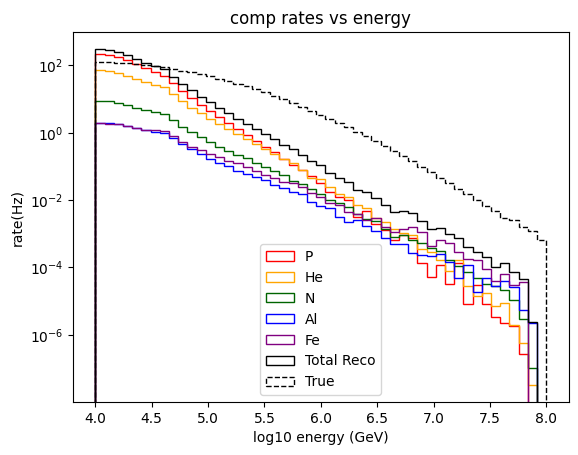

[4.125 4.375 4.625 4.875 5.125 5.375 5.75  6.25  7.25 ]


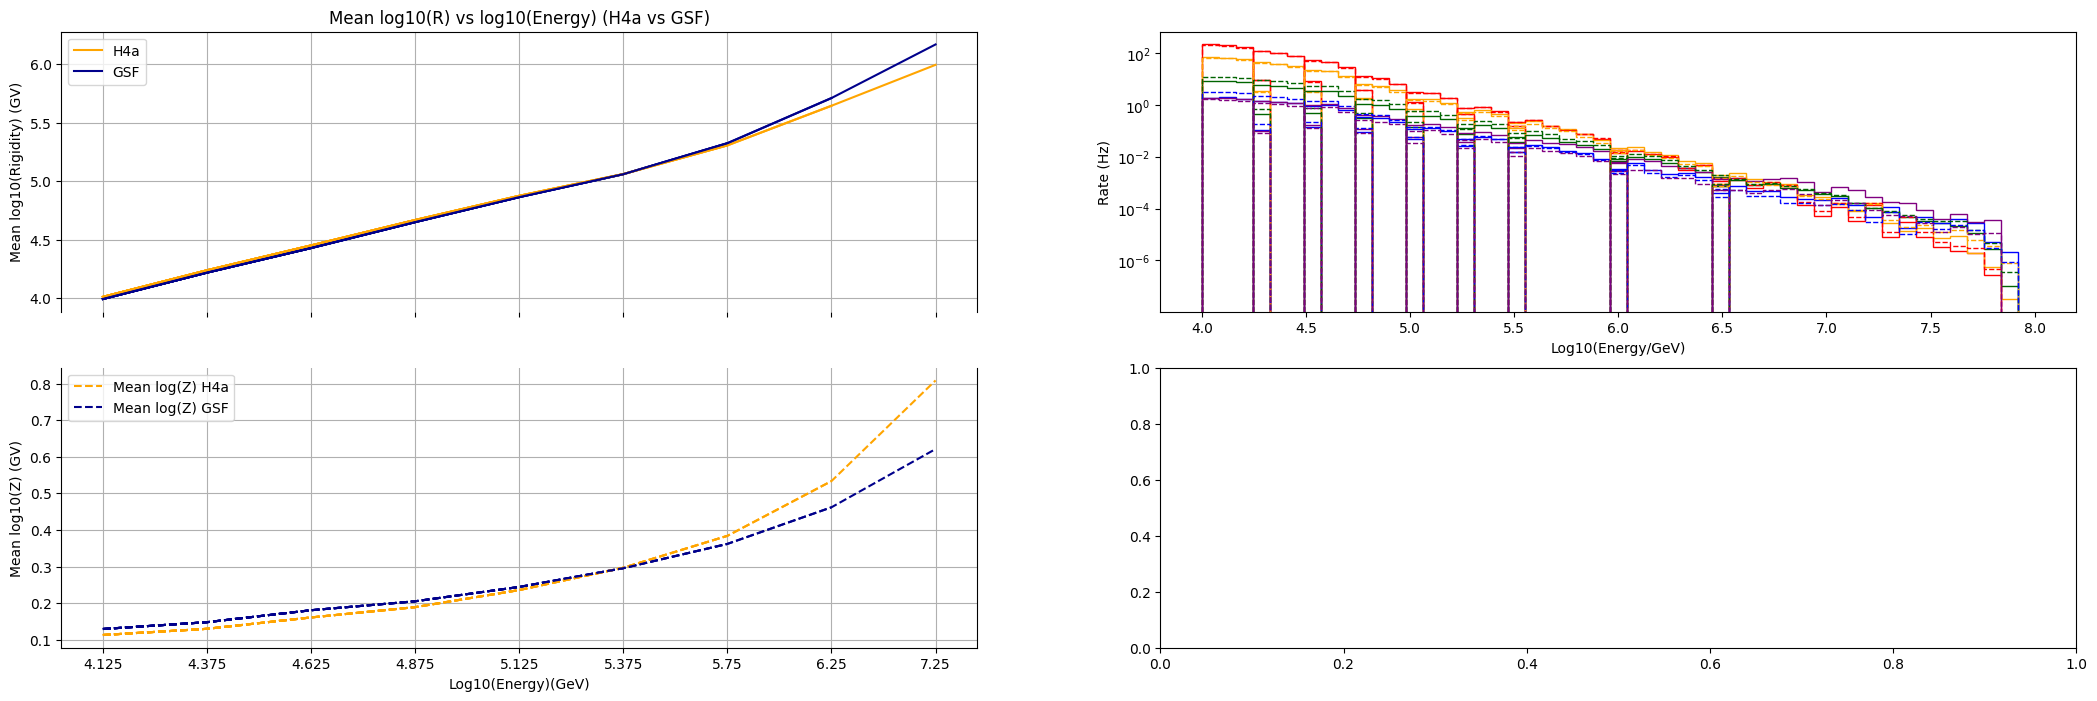

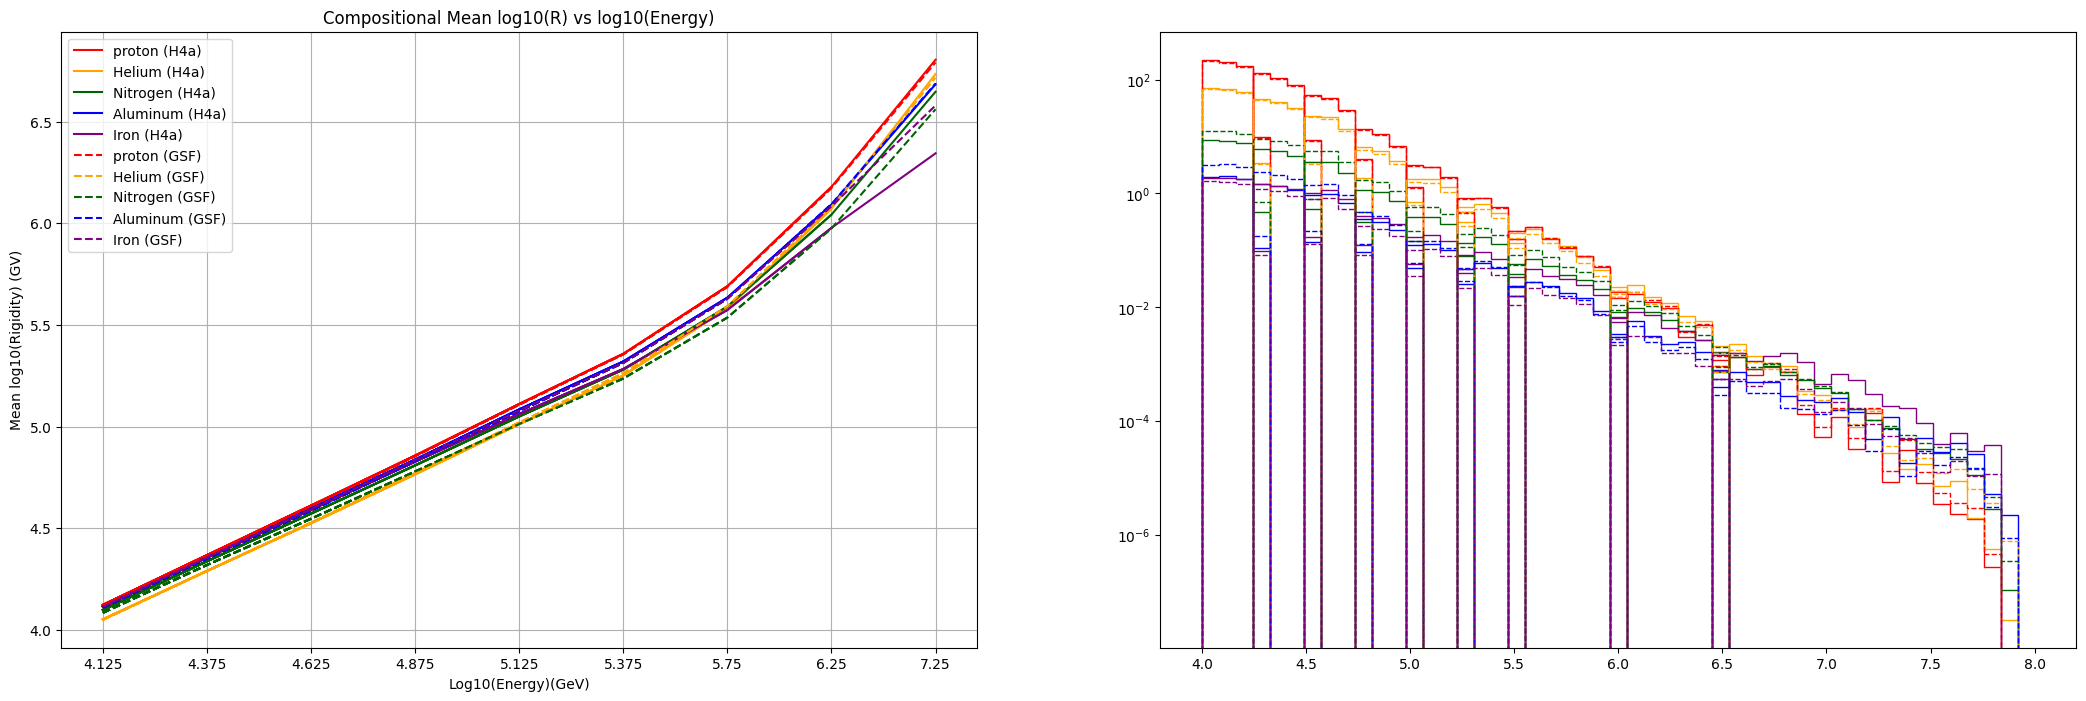

median LogR(4.125 logE bin): 0.22 TV
median LogR(4.375 logE bin): 0.47 TV
median LogR(4.625 logE bin): 0.72 TV
median LogR(4.875 logE bin): 0.97 TV
median LogR(5.125 logE bin): 1.22 TV
median LogR(5.375 logE bin): 1.47 TV
median LogR(5.75 logE bin): 1.78 TV
median LogR(6.25 logE bin): 2.28 TV
median LogR(7.25 logE bin): 3.02 TV


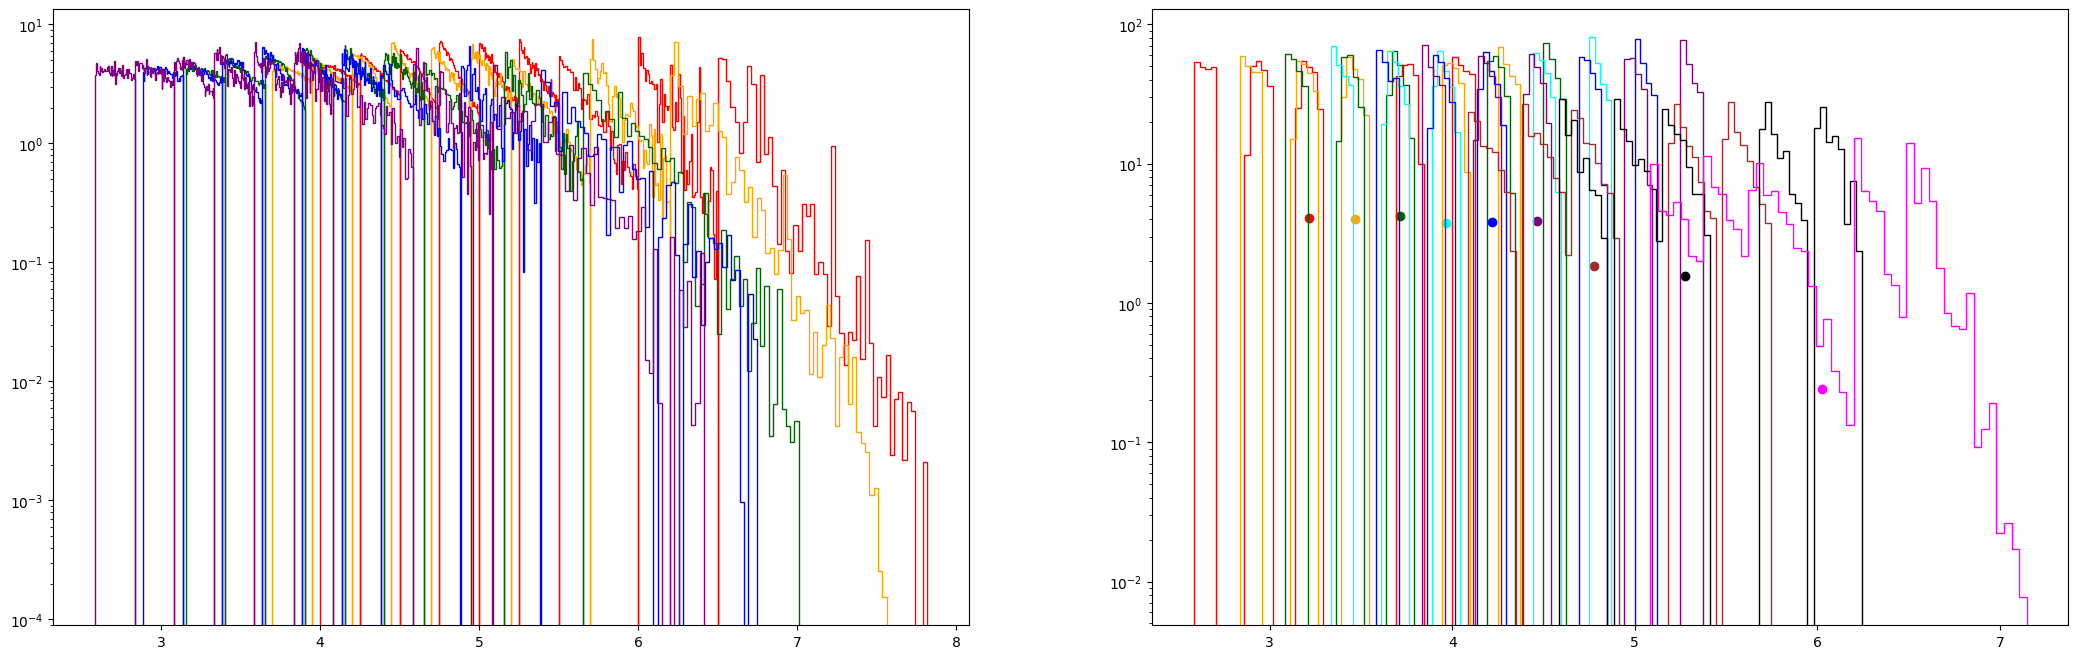

median LogR(4.125 logE bin): 0.22 TV
median LogR(4.375 logE bin): 0.47 TV
median LogR(4.625 logE bin): 0.72 TV
median LogR(4.875 logE bin): 0.97 TV
median LogR(5.125 logE bin): 1.22 TV
median LogR(5.375 logE bin): 1.47 TV
median LogR(5.75 logE bin): 1.78 TV
median LogR(6.25 logE bin): 2.28 TV
median LogR(7.25 logE bin): 3.02 TV


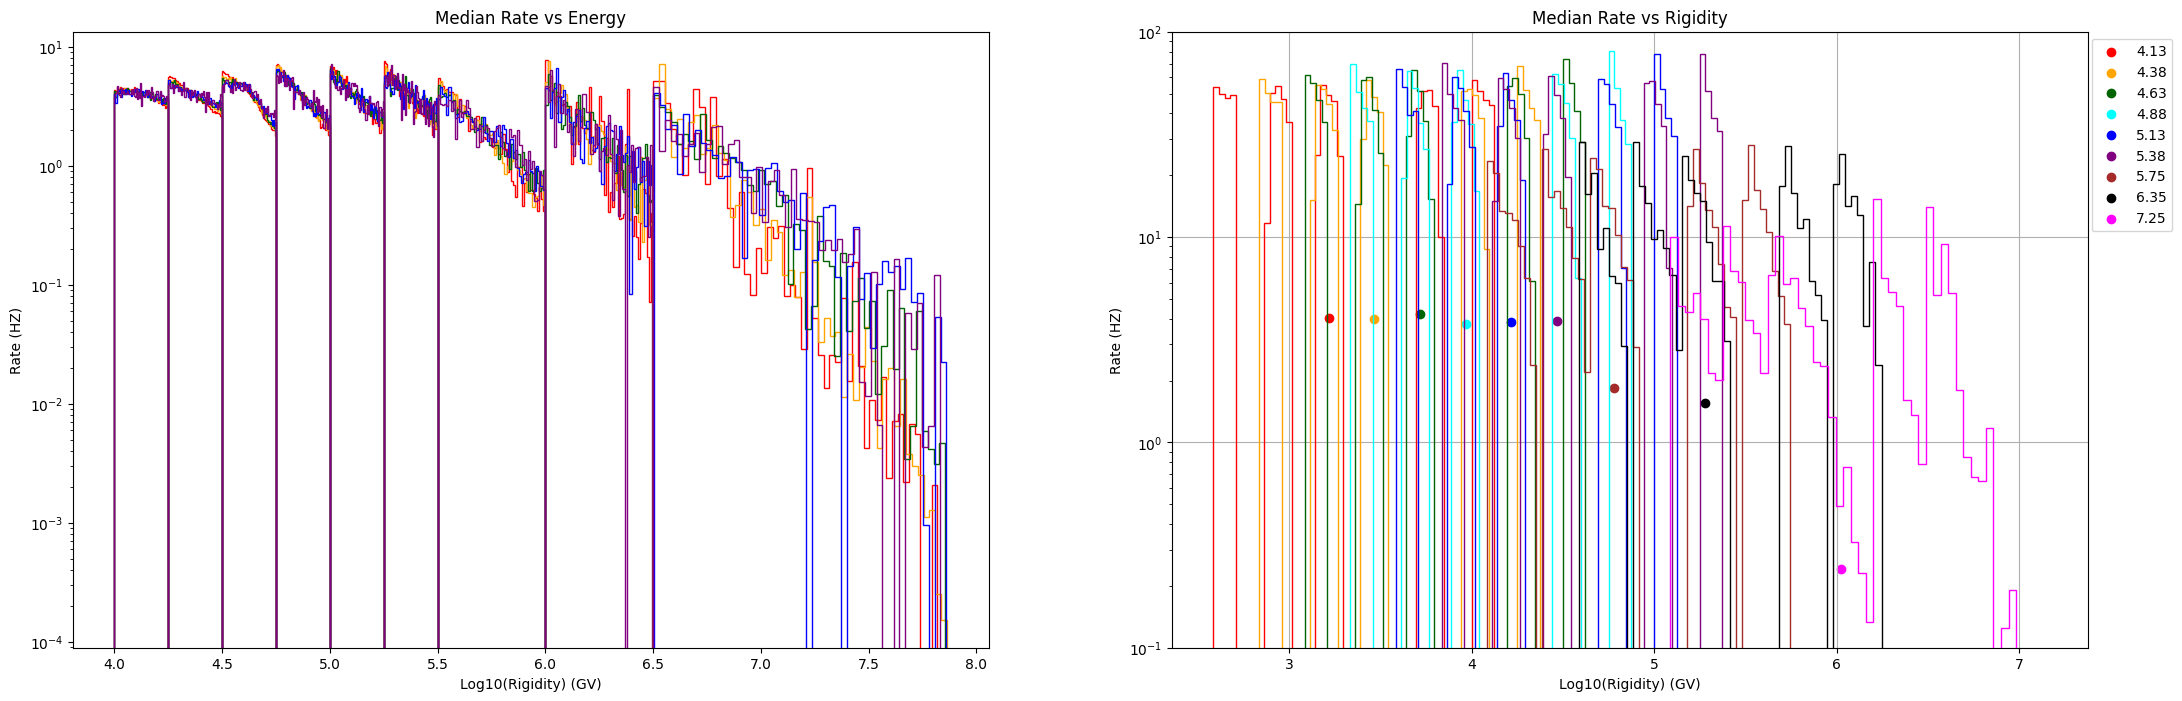

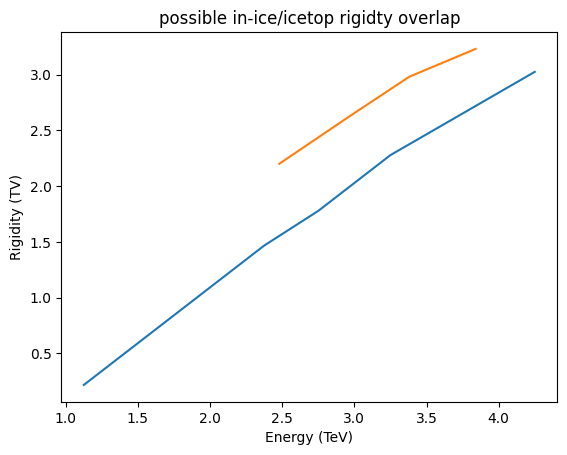

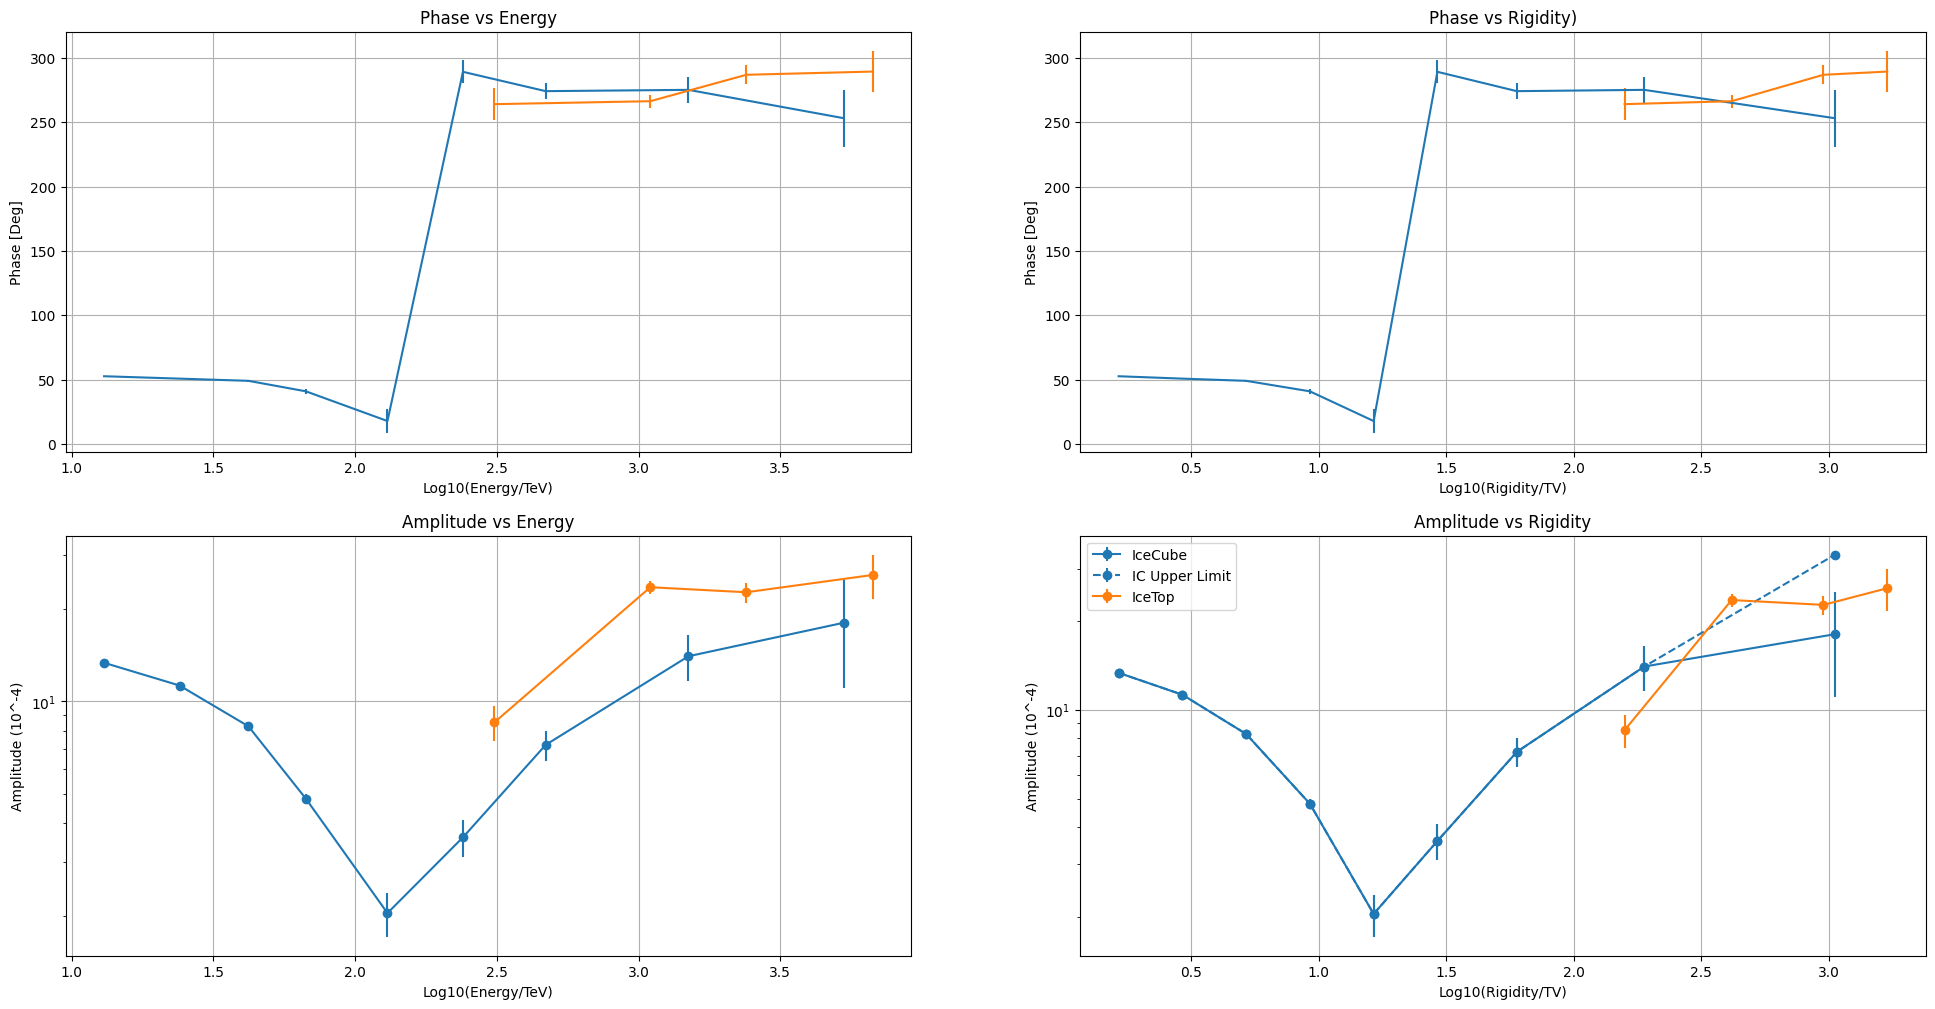

In [2]:
# Import libraries
import os, getpass


import numpy as np
import matplotlib.pyplot as plt

from pandas import DataFrame
# Import IceCube rigidity
%run reco_energy.ipynb

In [3]:
# Define a function for weighted means or weighted quantiles
def weighted_quantiles(values, weights, quantiles=0.5):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, np.array(quantiles) * c[-1])]]

In [4]:
# Load in the SIBYLL2.1 particle sims - note that these will also be your variable names
KEYS = ['energy', 'particle_type', 'hits', 'reco_pass', 'showerplane_zen', 'laputop_zen', 'Hweights', 'Gweights']

for key in KEYS:
    if os.path.isfile(f'/data/user/{getpass.getuser()}/it_anisotropy/{year}/{model}/{key}.npy'):
        with open(f'/data/user/{getpass.getuser()}/it_anisotropy/{year}/{model}/{key}.npy', 'rb') as file:
            globals()[key] = np.load(file)
    else:
        print(f'{key}.npy does not exist or is not in the required folder.')

particle_type.npy does not exist or is not in the required folder.


In [5]:
# Dictionary set-ups
# Set up composition-dependent dictionaries based on year and interaction model (some only have Fe and p)
if year == 2012 and (model == 'EPOS-LHC' or model == 'SIBYLL2.3' or model == 'QGSJET-II-04'):
    # Cuts for different compositions
    COMPS = {
        'proton': particle_type == 2.21200000e+03,
        'iron': particle_type == 1.00026056e+09,
        'true': np.tile(True, len(energy))
    }

    # Graph colors by composition
    COLORS = {
        'true' : 'black',
        'proton': 'red',
        'iron': 'blue'
    }

    # Graph labels by composition
    LABEL = {
        'true' : 'Data',
        'proton': 'p',
        'iron': 'Fe'
    }
else:
    # Cuts for different compositions
    COMPS = {
        'proton': particle_type == 2.21200000e+03,
        'helium' : particle_type == 1.00002004e+09,
        'oxygen': particle_type == 1.00008016e+09,
        'iron': particle_type == 1.00026056e+09,
        'true': np.tile(True, len(energy))
    }

    # Graph colors by composition
    COLORS = {
        'true' : 'black',
        'proton': 'red',
        'helium': 'orange',
        'oxygen': 'purple',
        'iron': 'blue'
    }

    # Graph labels by composition
    LABEL = {
        'true' : 'Data',
        'proton': 'p',
        'helium': 'He',
        'oxygen': 'O',
        'iron': 'Fe'
    }

# amu of different compositions
A = {
    'proton': 1.0073,
    'helium': 4.0026,
    'oxygen': 16,
    'iron': 55.845  
}

# Number of protons for different compositions
Z = {
    'proton': 1,
    'helium': 2,
    'nitrogen': 7,
    'aluminum': 13,
    'oxygen': 8,
    'iron': 26
}

# IceTop Tiers and quality cuts - quality cuts may not work well with some years and Tiers (e.g. reco_succeeded cancels out Tier 4 for 2012)
tier1_quality_cuts = (showerplane_zen < np.radians(55)) * (reco_pass == 1)
quality_cuts = (laputop_zen < np.radians(55)) * (reco_pass == 1)
# Calculation for the Tier offset per year
offset = round((year - 2011)/2)

if year < 2015:
    TIERS = {
        'Tier 1': (3 <= hits) * (hits < 5),
        'Tier 2': (5 <= hits) * (hits < 10 - offset) * quality_cuts,
        'Tier 3': (10 - offset <= hits) * (hits < 14 - offset) * quality_cuts,
        'Tier 4': (14 - offset <= hits) * quality_cuts
    }
    # Include Tier 1 quality cuts with year-dependent exceptions
    if year == 2012:
        TIERS['Tier 1'] *= (showerplane_zen < np.radians(55))
    else:
        TIERS['Tier 1'] *= tier1_quality_cuts

else:
    TIERS = {
        'Tier 3': (10 - offset <= hits) * (hits < 14 - offset),
        'Tier 4': (14 - offset <= hits) * quality_cuts
    }
    # Include default quality cuts with year-dependent exceptions
    if year == 2015:
        TIERS['Tier 3'] = (laputop_zen < np.radians(55))
    else:
        TIERS['Tier 3'] *= quality_cuts

# Weights
SIMS = {
    'H4a': Hweights,
    'GSF': Gweights
}

# Flux from histogram
FLUX = {
    'true'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'proton': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'helium': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'oxygen': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'iron'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},}
}

# Histogram bins
HBINS = {
    'true'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'proton': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'helium': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'oxygen': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'iron'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},}
}

# Linestyle by weights
LINESTYLE = {
    'H4a': None,
    'GSF': '--'
}

# Dictionary for total flux times log(Z) and for total flux across compositions for each Tier and weight.
TOTALS = {
    'numerator'  : {'Tier 1': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 2': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 3': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 4': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)}},
    'denominator': {'Tier 1': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 2': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 3': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 4': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)}}
}

# Table for partial compositions, ln(A), and mean log of rigidity, energy, and Z for each Tier and weight
if year < 2015:
    TABLE = {
        'H4a': {'Tier 1': {},
                'Tier 2': {},
                'Tier 3': {},
                'Tier 4': {}},
        'GSF': {'Tier 1': {},
                'Tier 2': {},
                'Tier 3': {},
                'Tier 4': {}}
    }
else:
    TABLE = {
        'H4a': {'Tier 3': {},
                'Tier 4': {}},
        'GSF': {'Tier 3': {},
                'Tier 4': {}}
    }
    
IC_COMPS = {
    'proton': pcut,
    'helium': Hecut,
    'nitrogen': Ncut,
    'aluminum': Alcut,
    'iron': Fecut
}

NameError: name 'particle_type' is not defined

In [11]:
# Calculate log10(rigidity)
# The -3 is to scale energy to TeV
rigidity = np.log10(energy) - 3

for comp, comp_cut in COMPS.items():
    if not comp == 'true':
        rigidity[comp_cut] -= np.log10(Z[comp])

# Weighted rate vs. energy

In [ ]:
# Prepare the graphs
ncols = len(TIERS)
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, tier_cut, ax in zip(TIERS.keys(), TIERS.values(), axs):
    # Print Tier for table
    print(tier)
    print('--------------------------')
    
    for weight_name, weights in SIMS.items():
        # Print weights for table
        print(weight_name)

        for comp, comp_cut in COMPS.items():
            # Combine cuts
            combined_cut = comp_cut * tier_cut

            # Set up the histogram arguments
            hist_args = {
                'bins': nbins,
                'linestyle': LINESTYLE[weight_name],
                'log': True,
                'label': f'{LABEL[comp]} ({weight_name})',
                'histtype':'step',
                'color': COLORS[comp]
            }

            # Graph primary energy
            FLUX[comp][tier][weight_name], HBINS[comp][tier][weight_name], patches1 = ax.hist(np.log10(energy[combined_cut]), weights=weights[combined_cut], **hist_args)

            # Print median energy and its first sigma
            if comp == 'proton' or comp == 'iron' or comp == 'true':
                print(f'    {comp}')
                print(f'        Median: {round(weighted_quantiles(energy[combined_cut] / 1000000, weights[combined_cut]), 2)} TeV')
                print(f'        68%: {round(weighted_quantiles(energy[combined_cut] / 1000000, weights[combined_cut], quantiles=.16), 2)}-{round(weighted_quantiles(energy[combined_cut] / 1000000, Hweights[combined_cut], .84), 2)} TeV')
                print()

    # Label axes and add legend and title
    ax.set_xlabel('$\log_{{10}}$(Energy) (GeV)', size=16)
    ax.set_ylabel('$\log_{{10}}$(Rates) (Hz)', size=16)
    ax.set_title(f'{year} {model} Energy vs. Weighted Rates for {tier}', size=24)
    ax.legend()

## Mean Atomic Charge

In [ ]:
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, ax in zip(TIERS, axs):    
    for weight_name in SIMS:
        for comp in COMPS:
            if not comp == 'true':
                # Sum flux at for each comp, Tier and weight times the number of protons for the comp
                TOTALS['numerator'][tier][weight_name] += FLUX[comp][tier][weight_name] * np.log10(Z[comp])

                # Sum flux at for each comp, Tier and weight
                TOTALS['denominator'][tier][weight_name] += FLUX[comp][tier][weight_name]

        # Calculate <Z>
        meanZ = TOTALS['numerator'][tier][weight_name] / TOTALS['denominator'][tier][weight_name]

        # Plot <Z> vs. energy
        ax.plot(HBINS['true'][tier][weight_name][:-1], meanZ, label=weight_name)

    ax.set_xlabel('$\log_{{10}}$(Energy/GeV)', size=16)
    ax.set_ylabel('Mean $\log_{{10}}(Z)$', size=16)
    ax.set_title(f'{year} {model} Mean $\log_{{10}}(Z)$ vs. Energy for {tier}', size=24)

    ax.legend()

## Fractional Compositions vs. Energy

In [ ]:
# Particle Fraction vs. Energy
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, ax in zip(TIERS, axs):
    for weight_name in SIMS:
        for comp in COMPS:
            # Plot fractional composition
            if not comp == 'true':
                ax.plot(HBINS[comp][tier][weight_name][:-1], FLUX[comp][tier][weight_name] / TOTALS['denominator'][tier][weight_name],
                label=f'{LABEL[comp]} ({weight_name})', linestyle=LINESTYLE[weight_name], color=COLORS[comp])

    ax.set_xlabel('$log_{{10}}$(Energy/GeV)', size=16)
    ax.set_ylabel('Fraction of Particles', size=16)
    ax.set_title(f'{year} {model} Particle Fraction vs. Energy for {tier}', size=24)

    ax.legend()

## Table of fractional comp, ln(A), median E, \<Z\>, and median rigidity

In [ ]:
print(f'{year} {model}')
print()

for weight_name, weights in SIMS.items():
    # Print weight name for data table
    print(weight_name)
    print()

    for tier, tier_cut in TIERS.items():
        # Start ln_A at zero
        ln_A = 0

        for comp in COMPS:
            if not comp == 'true':
                # Save the partial compositions to the table
                TABLE[weight_name][tier][f'{comp} part'] = round(np.mean(FLUX[comp][tier][weight_name]) / np.mean(TOTALS['denominator'][tier][weight_name]), 3)

                # Calculate the mean ln(A) with partial compositions
                ln_A += TABLE[weight_name][tier][f'{comp} part'] * np.log(A[comp])

        # Save ln(A) to the table
        TABLE[weight_name][tier]['ln(A)'] = round(ln_A, 3)
        
        # Calculate mean log E (Scaled to TeV), mean log Z, and finally mean log rigidity
        TABLE[weight_name][tier]['median(log(E))'] = round(weighted_quantiles(np.log10(energy)[tier_cut] - 3, weights=weights[tier_cut]), 3)
        TABLE[weight_name][tier]['<log(Z)>'] = round(np.mean(TOTALS['numerator'][tier][weight_name]) / np.mean(TOTALS['denominator'][tier][weight_name]), 3)
        TABLE[weight_name][tier]['median(log(R))'] = round(weighted_quantiles(rigidity[tier_cut], weights=weights[tier_cut]), 3)
        median_R = TABLE[weight_name][tier]['median(log(R))']

    # Print out the table for that weight
    print(DataFrame(TABLE[weight_name]))
    print()

In [ ]:
# Alternate median(log(R)) caluclation
COLS = {
    'H4a': 'blue',
    'GSF': 'orange'
}
fig, axs = plt.subplots(figsize=(13, 8), ncols=1)

for tier, tier_cut in TIERS.items():
    print(tier)
    print('----------------------')

    for weight_name, weihgts in SIMS.items():
        print(f'    {weight_name}')
        print(f'        Mean: {round(np.average(rigidity[tier_cut], weights=weights[tier_cut]), 3)}')
        print(f'        Median: {round(weighted_quantiles(rigidity[tier_cut], weights=weights[tier_cut]), 3)}')
        print()
        
        axs.scatter(tier, np.average(rigidity[tier_cut], weights=weights[tier_cut]), color=COLS[weight_name], label=f'Mean ({weight_name})', antialiased=True)
        axs.scatter(tier, weighted_quantiles(rigidity[tier_cut], weights=weights[tier_cut]), color=[0, 0, 0, 0], label=f'Median ({weight_name})', edgecolors=COLS[weight_name], antialiased=True)
        
axs.set_xlabel('Tier')
axs.set_ylabel('Median Rigidity (TV)')
axs.legend()

## Weighted rate vs rigidity

In [ ]:
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, tier_cut, ax in zip(TIERS.keys(), TIERS.values(), axs):
    rate = np.zeros(nbins)
    for weight_name, weights in SIMS.items():
        for comp, comp_cut in COMPS.items():
            # Set up the histogram arguments
            hist_args = {
                'bins': nbins,
                'linestyle': LINESTYLE[weight_name],
                'log': True,
                'label': f'{LABEL[comp]} ({weight_name})',
                'histtype':'step',
                'color': COLORS[comp]
            }

            # Graph rate vs. rigidity
            combined_cut = tier_cut * comp_cut
            rate = ax.hist(rigidity[combined_cut], weights=weights[combined_cut], **hist_args)
            #ax.scatter(weighted_quantiles(rigidity[combined_cut], weights=weights[combined_cut]), np.median(rate[0]), label=f'Median {comp} ({weight_name})', c=COLORS[comp])

    ax.set_xlabel('$\log_{{10}}$(Rigidity) (TV)', size=16)
    ax.set_ylabel('$\log_{{10}}$(Rate) (Hz)', size=16)
    ax.set_title(f'{year} {model} Rate vs. Rigidity for {tier}', size=24)
    ax.legend()

## Energy vs. rigidity

In [ ]:
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, tier_cut, ax in zip(TIERS.keys(), TIERS.values(), axs):
    for weight_name, weights in SIMS.items():
        for comp, comp_cut in COMPS.items():
            if not comp == 'true':
                rate = np.zeros(nbins)

                combined_cut = comp_cut * tier_cut
                # Graph rate vs. rigidity
                rate = ax.plot(np.log10(energy[combined_cut]), rigidity[combined_cut], linestyle=LINESTYLE[weight_name],
                        label=f'{LABEL[comp]} ({weight_name})', color=COLORS[comp])
    
    ax.set_xlabel('$\log_{{10}}$(Rigidity) (TV)', size=16)
    ax.set_ylabel('$\log_{{10}}$(Energy) (GeV)', size=16)
    ax.set_title(f'{year} {model} Energy vs. Rigidity', size=24)
    ax.legend()

# Dipole phase and amplitude

In [ ]:
fig, (ax0, ax1) = plt.subplots(figsize=(26, 8), ncols=2)
for weight_name in SIMS:
    # Dipole amplitude
    it_amplitude = 1.74 * np.array([4.9, 13.5, 11.9, 12.5])
    ic_amplitude = [13.33, 11.24, 8.28, 4.81, 2.04, 3.6, 7.2, 14.0, 18.0]

    # Dipole phase
    it_phase = [263.9, 266.2, 287.8, 295.9]
    ic_phase = [52.76, 50.91, 49.2, 41.05, 18.0, 289.0, 274.0, 275.0, 253.0]

    # Calculate Rigidity
    icetop_median_rigidity = np.array([TABLE[weight_name][tier]['median(log(R))'] for tier in TABLE[weight_name]]) + 3
    icecube_rigidity = d['reco_energy']
    for comp, comp_cut in IC_COMPS.items():
        icecube_rigidity[comp_cut] -= np.log10(Z[comp])
    
    icecube_median_rigidity = []
    for cut in BINS.values():
        if weight_name == 'H4a':
            icecube_median_rigidity.append(weighted_quantiles(icecube_rigidity[cut], d['GaisserH4a'][cut]))
        else:
            icecube_median_rigidity.append(weighted_quantiles(icecube_rigidity[cut], d['GlobalSplineFit5Comp'][cut]))

    # Errors
    it_amplitude_error = [1.1, 1.2, 1.7, 4.2]
    it_phase_err = [12.6, 5.0, 7.4, 16.1]

    ic_amplitude_error = [0.05, 0.05, 0.09, 0.17, 0.33, 0.5, 0.8, 2.4, 7]
    ic_phase_err = [0.20, 0.28, 0.6, 2.0, 9, 9, 6, 10, 22]

    # Plot amplitude
    ax0.set_yscale("log", nonpositive='mask')
    ax0.errorbar(icecube_median_rigidity, ic_amplitude, yerr=ic_amplitude_error, label=f'IceCube {weight_name}', c='blue', linestyle=LINESTYLE[weight_name], fmt='-o')
    ax0.errorbar(icetop_median_rigidity, it_amplitude, yerr=it_amplitude_error, label=f'IceTop {weight_name}', c='orange', linestyle=LINESTYLE[weight_name], fmt='-o')
    ax0.set_xlabel('$\log_{{10}}$(Rigidity) (GV)', size=16)
    ax0.set_ylabel('Amplitude ($10^{{-4}}$)', size=16)
    ax0.set_title(f'{year} {model} Dipole amplitude vs. rigidity', size=24)
    ax0.grid(visible=True)

    # Plot phase
    ax1.errorbar(icecube_median_rigidity, ic_phase, yerr=ic_phase_err, label=f'IceCube {weight_name}', c='blue', linestyle=LINESTYLE[weight_name], fmt='-o')
    ax1.errorbar(icetop_median_rigidity, it_phase, yerr=it_phase_err, label=f'IceTop {weight_name}', c='orange', linestyle=LINESTYLE[weight_name], fmt='-o')
    ax1.set_xlabel('$\log_{{10}}$(Rigidity) (GV)', size=16)
    ax1.set_ylabel('Phase ($\degree$)', size=16)
    ax1.set_title(f'{year} {model} Dipole phase vs. rigidity', size=24)
    ax1.grid(visible=True)

    plt.legend()